# Using a Deep Convolutional Neural Network to Recognize Fruits

In [11]:
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import os
from keras.utils import to_categorical

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Loading Data
I'm using the [fruits360 dataset](https://www.kaggle.com/moltean/fruits) from kaggle. I only read in ten random fruits at a time in order to spare my wimpy computer.

In [5]:
# pick 10 random fruits based on their containing folders in the training data
n_fruits = 10 
prediction_fruits = np.random.choice(os.listdir('fruits-360/Training/'), n_fruits)

In [7]:
# compile the file paths to all of the training/testing images for each type of fruit
train_img_urls = []
test_img_urls = []
train_labels = []
test_labels = []
train_prefix = 'fruits-360/Training/%s/'
test_prefix = 'fruits-360/Test/%s/'
for i in prediction_fruits:
    train_fruit_urls = [(train_prefix % i) + j for j in os.listdir(train_prefix % i)]
    test_fruit_urls = [(test_prefix % i) + j for j in os.listdir(test_prefix % i)]
    train_fruit_labels = [i] * len(train_fruit_urls)
    test_fruit_labels = [i] * len(test_fruit_urls)
    train_img_urls += train_fruit_urls 
    test_img_urls += test_fruit_urls 
    # collect the true labels (fruit name) for each training/testing sample
    train_labels += train_fruit_labels
    test_labels += test_fruit_labels

In [8]:
# read in the images as BGR (OpenCV does this instead of RGB for some reason) data 
train_images = np.stack([cv2.imread(i, 1) for i in train_img_urls])
test_images = np.stack([cv2.imread(i, 1) for i in test_img_urls])

Images are of size 100 x 100

In [9]:
print(train_images.shape)
print(test_images.shape)

(4882, 100, 100, 3)
(1644, 100, 100, 3)


### Data Setup

Map the fruit names to a one-hot encoding

In [19]:
label_mapping = {e:i for i, e in enumerate(np.unique(test_labels))}

In [21]:
label_mapping

{'Guava': 0,
 'Lemon Meyer': 1,
 'Limes': 2,
 'Peach Flat': 3,
 'Physalis': 4,
 'Tamarillo': 5,
 'Tangelo': 6,
 'Tomato 4': 7}

In [23]:
train_int_labels = np.vectorize(label_mapping.get)(np.array(train_labels))
test_int_labels = np.vectorize(label_mapping.get)(np.array(test_labels))

In [26]:
train_one_hot_labels = to_categorical(train_int_labels, num_classes=n_fruits)
test_one_hot_labels = to_categorical(test_int_labels, num_classes=n_fruits)

### Model Setup
I used Keras to make a Convolutional Neural Network with the following structure:

100 x 100 x 3 image
=>


In [30]:
batch_size = 100

In [57]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=train_images.shape[1:]),
    Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),   
    Dropout(0.25),
    
    Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(n_fruits, activation='softmax')    

])

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 5, 5, 64)          0         
__________

In [59]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
model.fit(train_images, train_one_hot_labels, epochs=10, batch_size=75)
score = model.evaluate(test_images, test_one_hot_labels, batch_size=128)

Epoch 1/10
4882/4882 [==============================] - 243s 50ms/step - loss: 2.1450 - acc: 0.2796
Epoch 2/10
4882/4882 [==============================] - 236s 48ms/step - loss: 1.1134 - acc: 0.5686
Epoch 3/10
4882/4882 [==============================] - 234s 48ms/step - loss: 0.7807 - acc: 0.6911
Epoch 4/10
4882/4882 [==============================] - 235s 48ms/step - loss: 0.6133 - acc: 0.7458
Epoch 5/10
4882/4882 [==============================] - 234s 48ms/step - loss: 0.4121 - acc: 0.8376
Epoch 6/10
4882/4882 [==============================] - 232s 47ms/step - loss: 0.3422 - acc: 0.8677
Epoch 7/10
4882/4882 [==============================] - 230s 47ms/step - loss: 0.2814 - acc: 0.8896
Epoch 8/10
4882/4882 [==============================] - 231s 47ms/step - loss: 0.2860 - acc: 0.8865
Epoch 9/10
4882/4882 [==============================] - 231s 47ms/step - loss: 0.2264 - acc: 0.9101
Epoch 10/10
1644/1644 [==============================] - 26s 16ms/step


In [61]:
score

[0.07113291011030452, 0.9927007299270073]

In [118]:
np.round(model.predict(test_images[5:6],))

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [74]:
label_mapping

{'Guava': 0,
 'Lemon Meyer': 1,
 'Limes': 2,
 'Peach Flat': 3,
 'Physalis': 4,
 'Tamarillo': 5,
 'Tangelo': 6,
 'Tomato 4': 7}

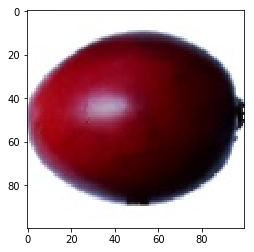

In [119]:
plt.imshow(test_images[5][:,:,[2,1,0]])

In [107]:
test_img = cv2.imread('fruits-360/Training/Apple Braeburn/100_100.jpg', 1)

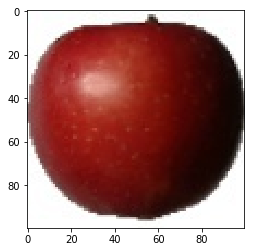

In [108]:
plt.imshow(test_img[:,:,[2,1,0]])

In [125]:
model.save('deep-cnn-fruits.h5')